In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from feature_vae import FeatureVAE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
z_dim = 20
beta = 1

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3

updates_per_epoch = 1
num_displays = 3

In [3]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
shapes_meta = pd.read_csv('shapes.csv')
shapes_meta.head()

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,hexagon,straw,0.988235,0.964706,0.474510,1.144512,1.144512,0.000000,0.000000,0.0,0.0,NaN,False
1,arrow,seafoam green,0.478431,0.976471,0.670588,1.000000,1.000000,118.709256,0.000000,0.0,0.0,NaN,False
2,hexagon,poop green,0.435294,0.486275,0.000000,1.000000,1.000000,34.431965,-14.320476,0.0,0.0,NaN,True
3,rectangle,mustard brown,0.674510,0.494118,0.015686,1.311106,1.045512,0.000000,0.000000,0.0,0.0,NaN,False
4,ellipse,aqua,0.074510,0.917647,0.788235,1.227175,0.595685,0.000000,0.000000,0.0,0.0,NaN,False


In [6]:
resize = transforms.Resize(64)
shapes = resize(torch.load('shapes.pt').permute(0, 3, 1, 2) / 255)
del resize
shapes.shape

torch.Size([20000, 3, 64, 64])

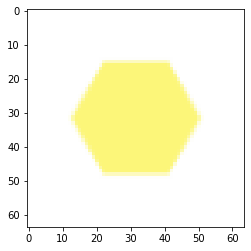

In [7]:
plt.imshow(shapes[0].permute(1, 2, 0).cpu())

In [8]:
train, valid = train_test_split(shapes, test_size=0.1, random_state=rand_state)
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
del shapes

In [9]:
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
train_meta = torch.tensor(train_meta.iloc[:,2:5].values).float()
valid_meta = torch.tensor(valid_meta.iloc[:,2:5].values).float()

In [10]:
num_features = train_meta.size(1)

In [11]:
from torch.utils.data import Dataset

bce_loss = nn.BCELoss(reduction='sum')
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

class DatasetWrapper(Dataset):
    def __init__(self, imgs, latent_supervision):
        self.imgs = imgs
        self.latent_supervision = latent_supervision
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return self.imgs[idx].to(device), self.latent_supervision[idx].to(device)

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████▋| 281/282 [00:08<00:00, 71.57it/s]

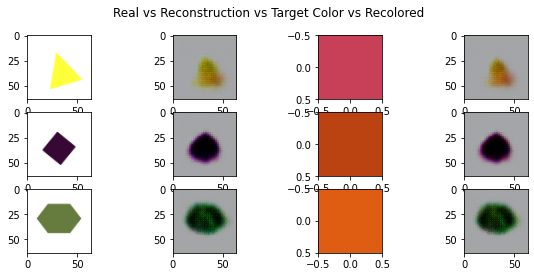

Epoch 1 | train loss 7059.66 | valid loss 6106.42: 100%|█████████████████████████████| 282/282 [00:09<00:00, 29.16it/s]
Epoch 2:  99%|█████████████████████████████████████████████████████████████████████▉ | 278/282 [00:03<00:00, 72.54it/s]

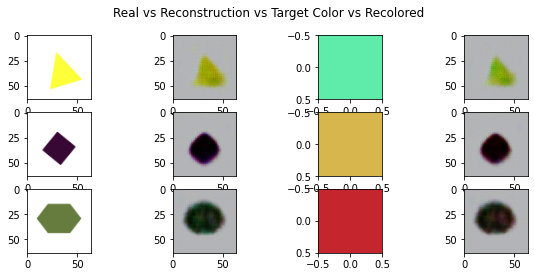

Epoch 2 | train loss 5525.77 | valid loss 5038.48: 100%|█████████████████████████████| 282/282 [00:04<00:00, 60.54it/s]
Epoch 3:  99%|██████████████████████████████████████████████████████████████████████▏| 279/282 [00:03<00:00, 71.20it/s]

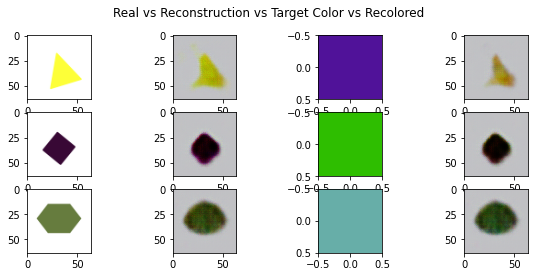

Epoch 3 | train loss 4574.95 | valid loss 4156.15: 100%|█████████████████████████████| 282/282 [00:04<00:00, 61.79it/s]
Epoch 4:  99%|█████████████████████████████████████████████████████████████████████▉ | 278/282 [00:03<00:00, 71.82it/s]

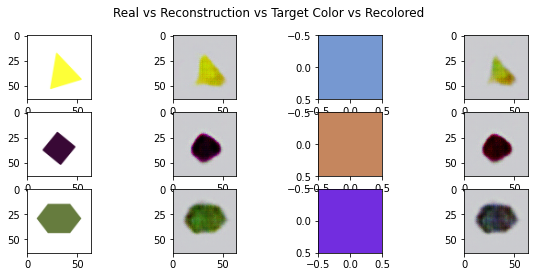

Epoch 4 | train loss 3871.85 | valid loss 3570.67: 100%|█████████████████████████████| 282/282 [00:04<00:00, 60.30it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████████████████▏| 279/282 [00:03<00:00, 72.65it/s]

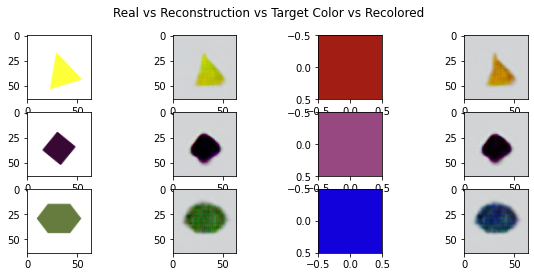

Epoch 5 | train loss 3344.56 | valid loss 3196.23: 100%|█████████████████████████████| 282/282 [00:04<00:00, 62.20it/s]
Epoch 6:  98%|█████████████████████████████████████████████████████████████████████▋ | 277/282 [00:03<00:00, 72.53it/s]

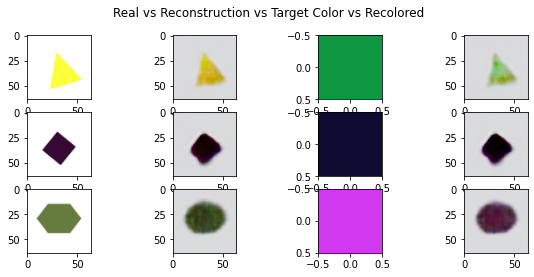

Epoch 6 | train loss 2934.36 | valid loss 2822.95: 100%|█████████████████████████████| 282/282 [00:04<00:00, 61.90it/s]
Epoch 7:  99%|██████████████████████████████████████████████████████████████████████▏| 279/282 [00:03<00:00, 72.30it/s]

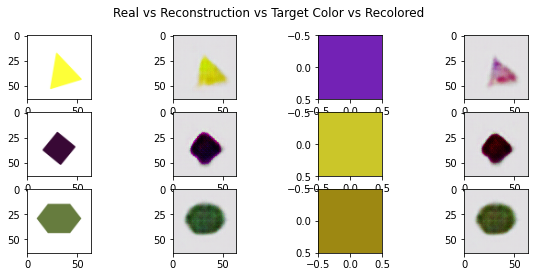

Epoch 7 | train loss 2623.29 | valid loss 2634.53: 100%|█████████████████████████████| 282/282 [00:04<00:00, 60.46it/s]
Epoch 8:  99%|██████████████████████████████████████████████████████████████████████▏| 279/282 [00:03<00:00, 72.34it/s]

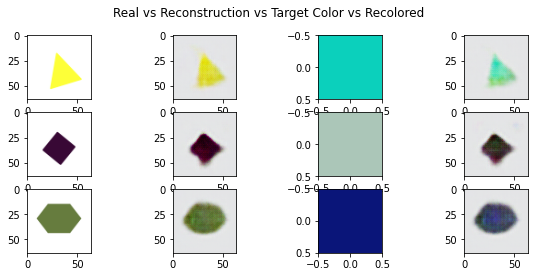

Epoch 8 | train loss 2367.71 | valid loss 2224.96: 100%|█████████████████████████████| 282/282 [00:04<00:00, 61.44it/s]
Epoch 9:  99%|██████████████████████████████████████████████████████████████████████▏| 279/282 [00:03<00:00, 72.09it/s]

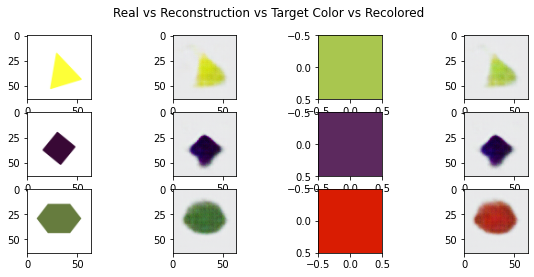

Epoch 9 | train loss 2163.18 | valid loss 2138.91: 100%|█████████████████████████████| 282/282 [00:04<00:00, 60.24it/s]
Epoch 10:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 72.26it/s]

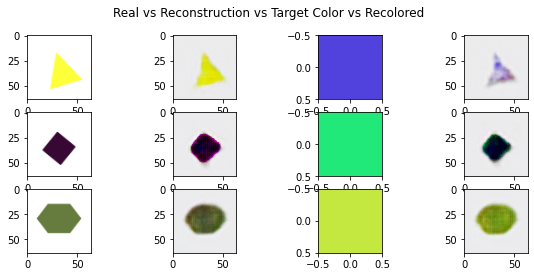

Epoch 10 | train loss 1998.78 | valid loss 2035.73: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.87it/s]
Epoch 11:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 71.28it/s]

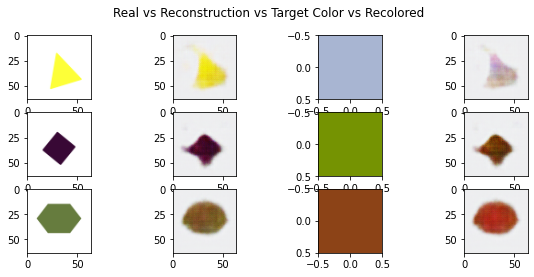

Epoch 11 | train loss 1863.89 | valid loss 1876.24: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.69it/s]
Epoch 12:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 72.49it/s]

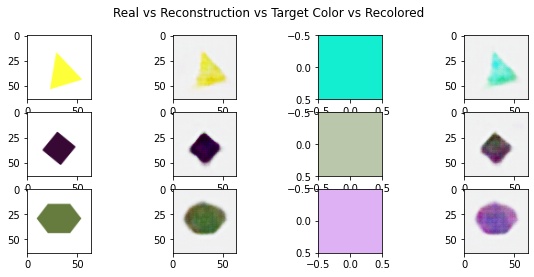

Epoch 12 | train loss 1760.29 | valid loss 1674.81: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.16it/s]
Epoch 13:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 72.42it/s]

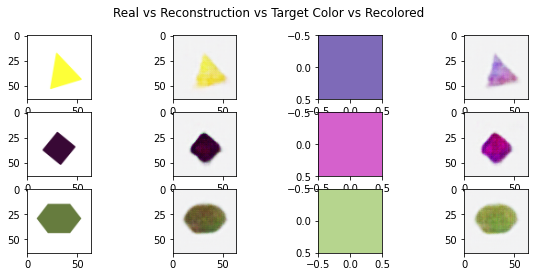

Epoch 13 | train loss 1656.38 | valid loss 1603.83: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.77it/s]
Epoch 14:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 72.68it/s]

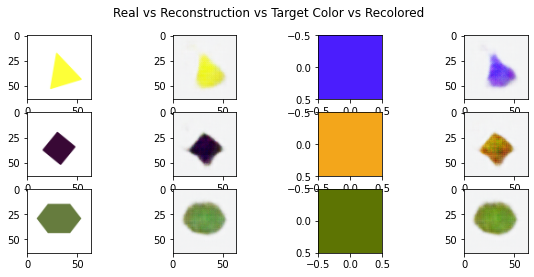

Epoch 14 | train loss 1570.27 | valid loss 1645.57: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.08it/s]
Epoch 15:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 72.15it/s]

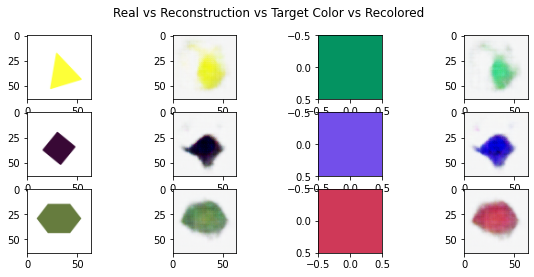

Epoch 15 | train loss 1511.27 | valid loss 1872.59: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.68it/s]
Epoch 16:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 72.30it/s]

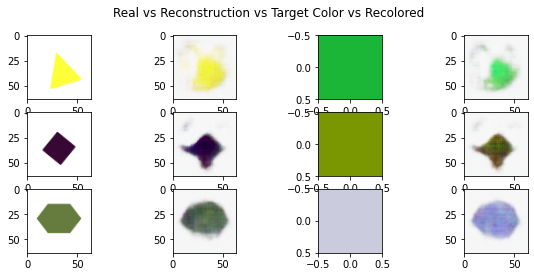

Epoch 16 | train loss 1448.65 | valid loss 1781.88: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.76it/s]
Epoch 17:  99%|█████████████████████████████████████████████████████████████████████ | 278/282 [00:03<00:00, 71.78it/s]

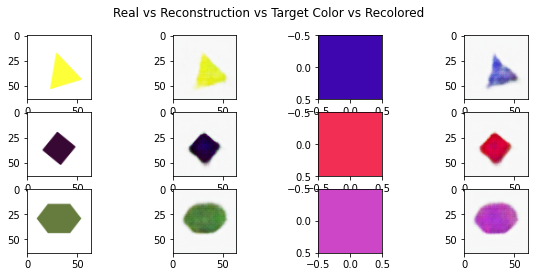

Epoch 17 | train loss 1410.97 | valid loss 1392.52: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.00it/s]
Epoch 18: 100%|█████████████████████████████████████████████████████████████████████▊| 281/282 [00:03<00:00, 71.43it/s]

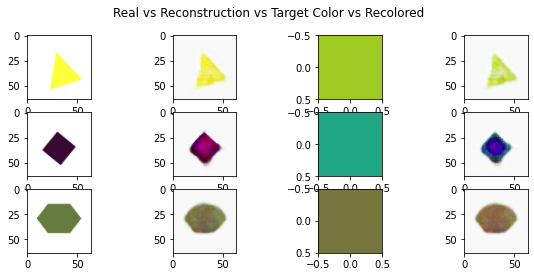

Epoch 18 | train loss 1360.18 | valid loss 1392.30: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.72it/s]
Epoch 19:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 72.05it/s]

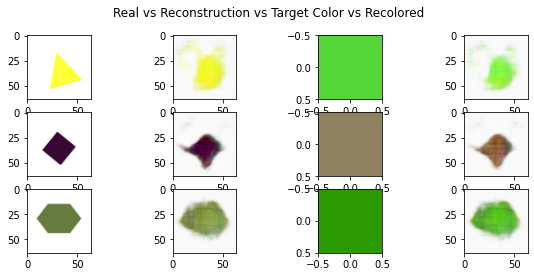

Epoch 19 | train loss 1316.96 | valid loss 1671.13: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.13it/s]
Epoch 20:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 71.74it/s]

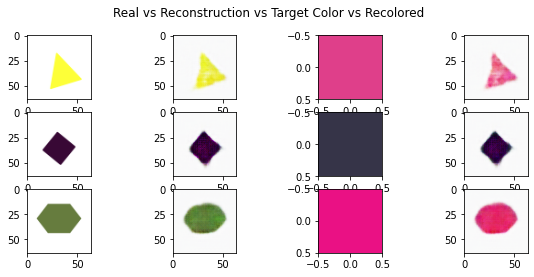

Epoch 20 | train loss 1303.63 | valid loss 1296.54: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.42it/s]
Epoch 21:  98%|████████████████████████████████████████████████████████████████████▌ | 276/282 [00:03<00:00, 71.24it/s]

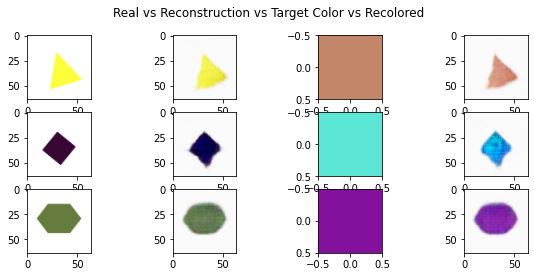

Epoch 21 | train loss 1270.22 | valid loss 1315.68: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.76it/s]
Epoch 22:  99%|█████████████████████████████████████████████████████████████████████ | 278/282 [00:03<00:00, 71.30it/s]

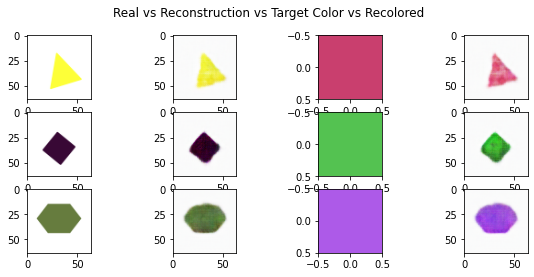

Epoch 22 | train loss 1252.15 | valid loss 1244.49: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.56it/s]
Epoch 23:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 71.63it/s]

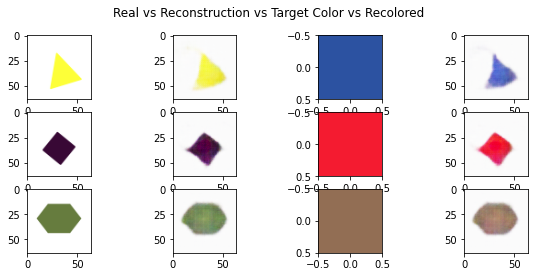

Epoch 23 | train loss 1207.20 | valid loss 1268.40: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.29it/s]
Epoch 24:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 71.38it/s]

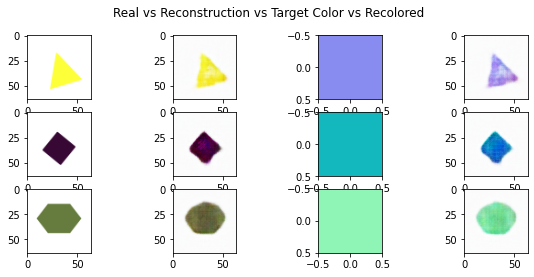

Epoch 24 | train loss 1189.88 | valid loss 1215.05: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.43it/s]
Epoch 25:  99%|█████████████████████████████████████████████████████████████████████▎| 279/282 [00:03<00:00, 71.23it/s]

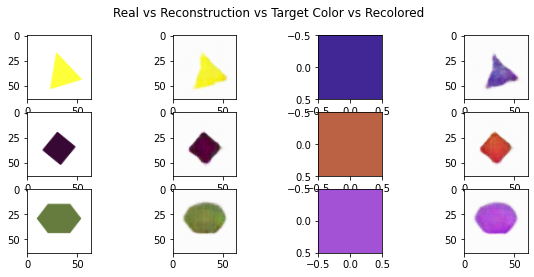

Epoch 25 | train loss 1159.65 | valid loss 1157.13: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.70it/s]
Epoch 26:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 71.07it/s]

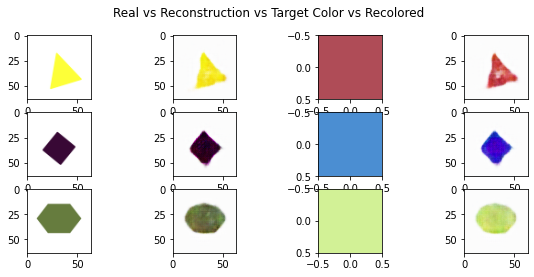

Epoch 26 | train loss 1161.75 | valid loss 1231.89: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.03it/s]
Epoch 27:  98%|████████████████████████████████████████████████████████████████████▌ | 276/282 [00:03<00:00, 70.71it/s]

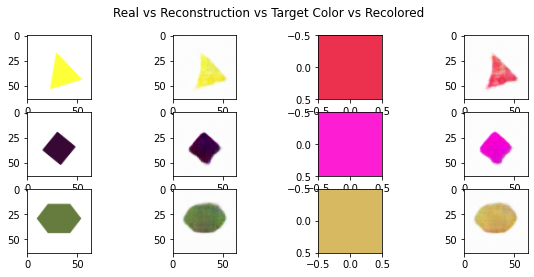

Epoch 27 | train loss 1134.87 | valid loss 1144.80: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.12it/s]
Epoch 28:  98%|████████████████████████████████████████████████████████████████████▌ | 276/282 [00:03<00:00, 69.86it/s]

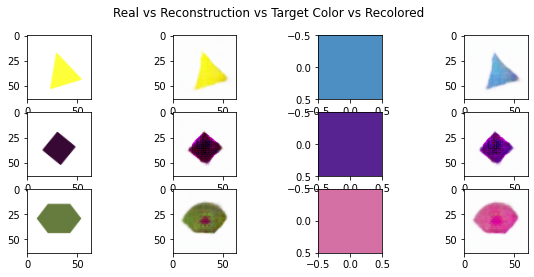

Epoch 28 | train loss 1120.11 | valid loss 1195.79: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.72it/s]
Epoch 29:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 71.08it/s]

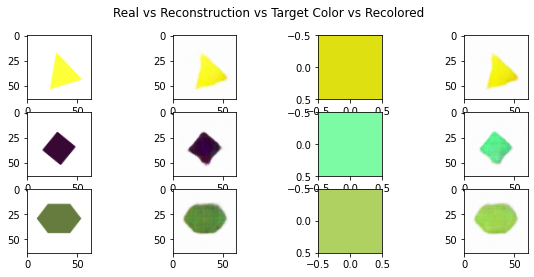

Epoch 29 | train loss 1115.16 | valid loss 1116.50: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.22it/s]
Epoch 30:  98%|████████████████████████████████████████████████████████████████████▎ | 275/282 [00:03<00:00, 71.29it/s]

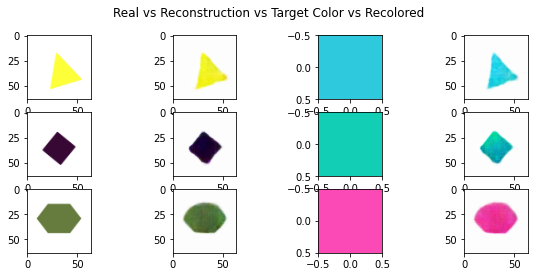

Epoch 30 | train loss 1096.42 | valid loss 1114.03: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.84it/s]
Epoch 31:  99%|█████████████████████████████████████████████████████████████████████▌| 280/282 [00:03<00:00, 71.34it/s]

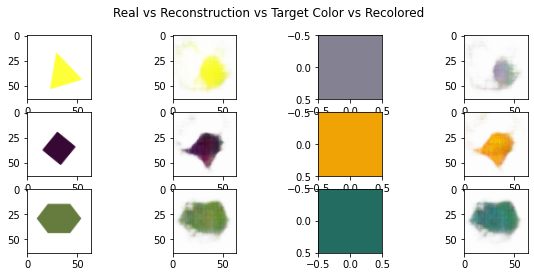

Epoch 31 | train loss 1087.50 | valid loss 1573.75: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.24it/s]
Epoch 32:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 71.00it/s]

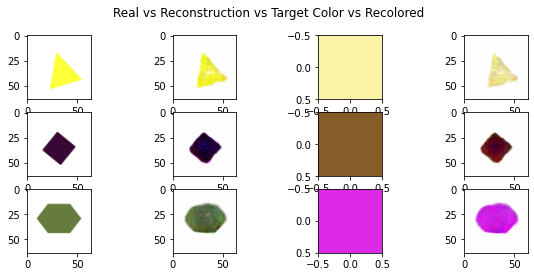

Epoch 32 | train loss 1083.20 | valid loss 1161.74: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.59it/s]
Epoch 33:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 71.39it/s]

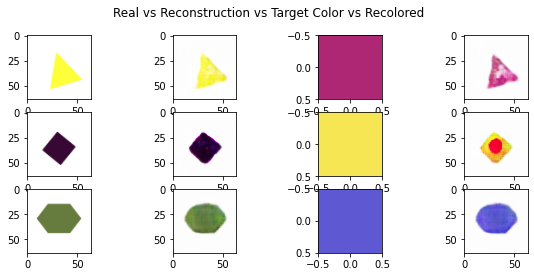

Epoch 33 | train loss 1069.39 | valid loss 1159.56: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.99it/s]
Epoch 34:  98%|████████████████████████████████████████████████████████████████████▌ | 276/282 [00:04<00:00, 65.85it/s]

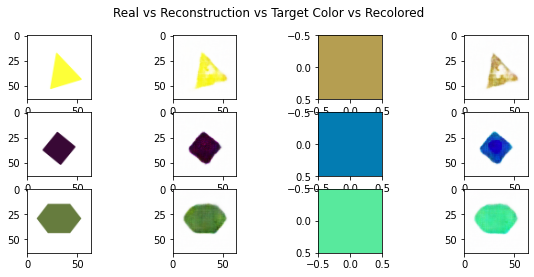

Epoch 34 | train loss 1061.63 | valid loss 1095.36: 100%|████████████████████████████| 282/282 [00:04<00:00, 57.76it/s]
Epoch 35:  98%|████████████████████████████████████████████████████████████████████▌ | 276/282 [00:03<00:00, 70.55it/s]

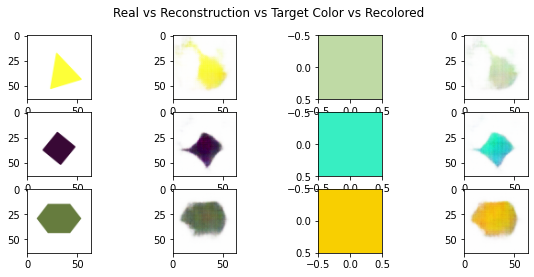

Epoch 35 | train loss 1057.36 | valid loss 1316.47: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.66it/s]
Epoch 36:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 70.47it/s]

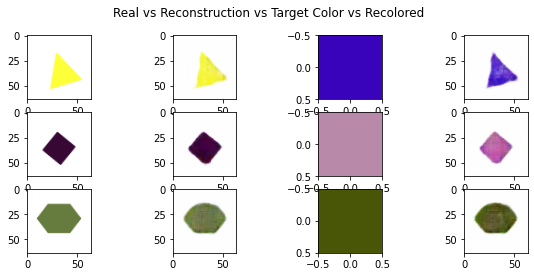

Epoch 36 | train loss 1066.24 | valid loss 1068.65: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.89it/s]
Epoch 37:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 69.81it/s]

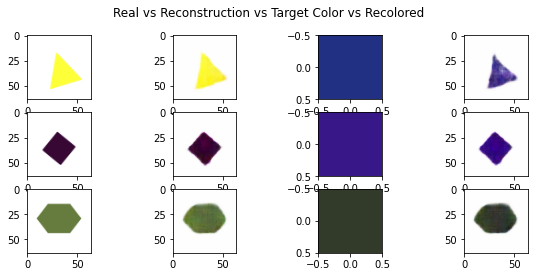

Epoch 37 | train loss 1045.74 | valid loss 1057.13: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.38it/s]
Epoch 38:  99%|█████████████████████████████████████████████████████████████████████ | 278/282 [00:03<00:00, 71.00it/s]

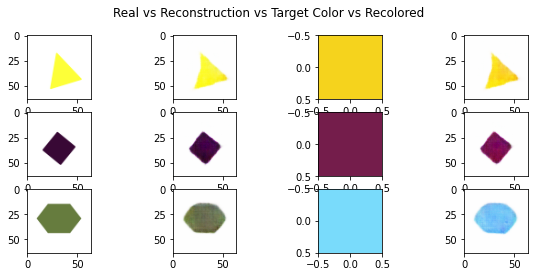

Epoch 38 | train loss 1043.47 | valid loss 1061.51: 100%|████████████████████████████| 282/282 [00:04<00:00, 61.22it/s]
Epoch 39:  98%|████████████████████████████████████████████████████████████████████▎ | 275/282 [00:03<00:00, 71.07it/s]

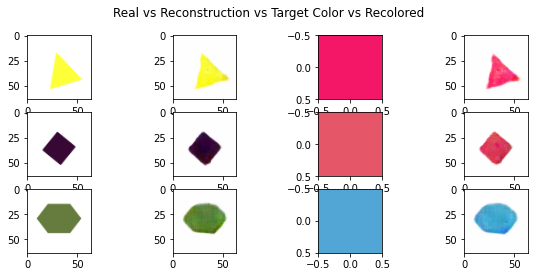

Epoch 39 | train loss 1035.02 | valid loss 1076.43: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.19it/s]
Epoch 40:  98%|████████████████████████████████████████████████████████████████████▎ | 275/282 [00:03<00:00, 71.38it/s]

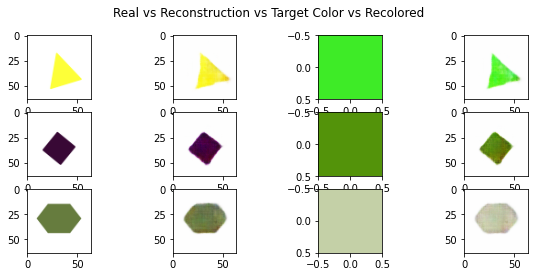

Epoch 40 | train loss 1033.44 | valid loss 1062.23: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.64it/s]
Epoch 41:  97%|████████████████████████████████████████████████████████████████████  | 274/282 [00:03<00:00, 71.50it/s]

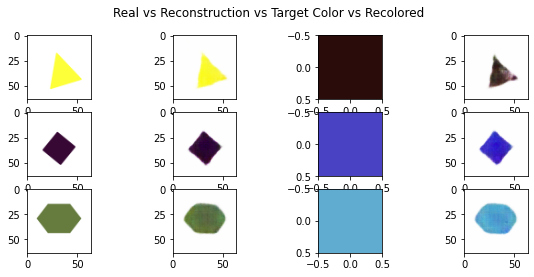

Epoch 41 | train loss 1030.09 | valid loss 1036.69: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.96it/s]
Epoch 42:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 71.21it/s]

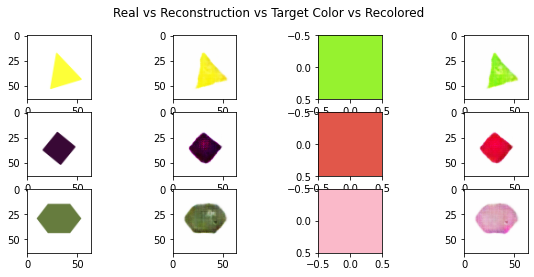

Epoch 42 | train loss 1024.67 | valid loss 1125.01: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.71it/s]
Epoch 43:  98%|████████████████████████████████████████████████████████████████████▎ | 275/282 [00:03<00:00, 71.06it/s]

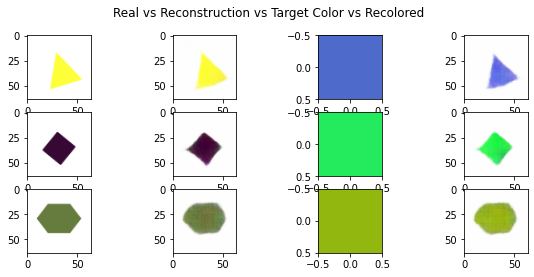

Epoch 43 | train loss 1020.07 | valid loss 1079.86: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.70it/s]
Epoch 44:  98%|████████████████████████████████████████████████████████████████████▌ | 276/282 [00:03<00:00, 71.44it/s]

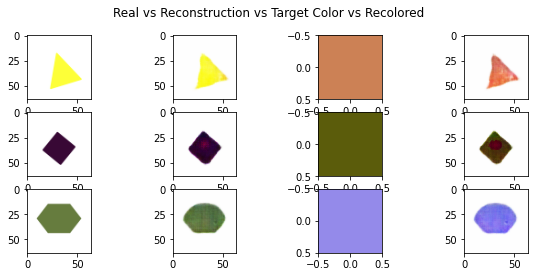

Epoch 44 | train loss 1018.88 | valid loss 1059.26: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.48it/s]
Epoch 45:  99%|█████████████████████████████████████████████████████████████████████ | 278/282 [00:03<00:00, 71.55it/s]

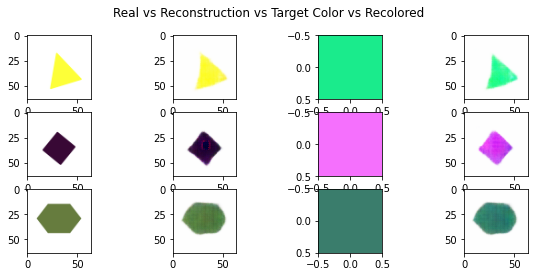

Epoch 45 | train loss 1015.78 | valid loss 1074.00: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.30it/s]
Epoch 46:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 69.75it/s]

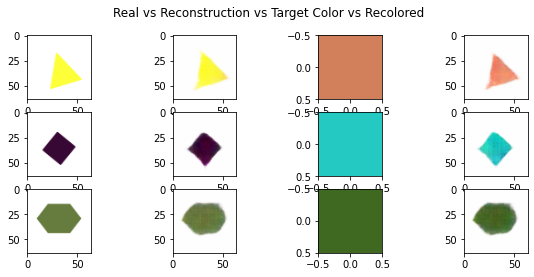

Epoch 46 | train loss 1013.92 | valid loss 1065.95: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.89it/s]
Epoch 47:  99%|█████████████████████████████████████████████████████████████████████▌| 280/282 [00:03<00:00, 71.05it/s]

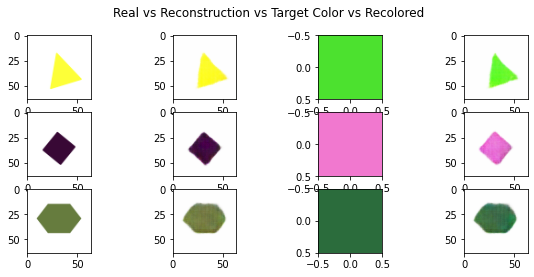

Epoch 47 | train loss 1011.59 | valid loss 1022.12: 100%|████████████████████████████| 282/282 [00:04<00:00, 58.59it/s]
Epoch 48:  98%|████████████████████████████████████████████████████████████████████▌ | 276/282 [00:03<00:00, 71.19it/s]

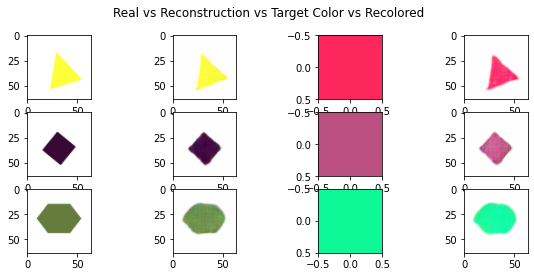

Epoch 48 | train loss 1008.62 | valid loss 1037.77: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.48it/s]
Epoch 49:  98%|████████████████████████████████████████████████████████████████████▌ | 276/282 [00:03<00:00, 69.78it/s]

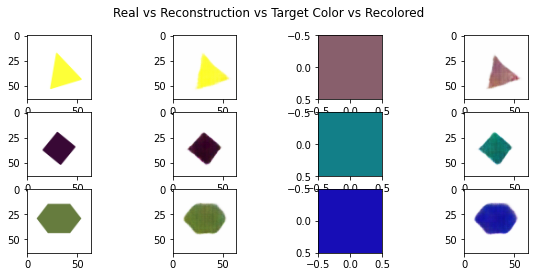

Epoch 49 | train loss 1009.56 | valid loss 1023.49: 100%|████████████████████████████| 282/282 [00:04<00:00, 59.07it/s]
Epoch 50:  98%|████████████████████████████████████████████████████████████████████▊ | 277/282 [00:03<00:00, 70.99it/s]

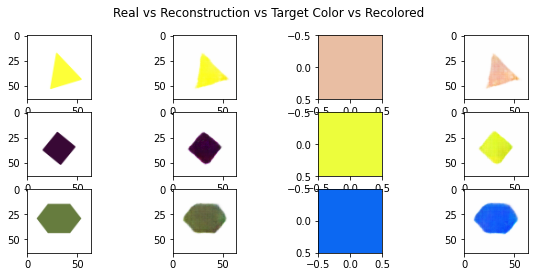

Epoch 50 | train loss 1005.50 | valid loss 1032.33: 100%|████████████████████████████| 282/282 [00:04<00:00, 60.67it/s]


In [12]:
from torch.utils.data import DataLoader

net = FeatureVAE(z_dim, num_features)
net = net.to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

train_dataloader = DataLoader(DatasetWrapper(train, train_meta), batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(DatasetWrapper(valid, valid_meta), batch_size=batch_size, shuffle=False)

num_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)


train_losses, valid_losses = [], []

update_idxs = set([i * (num_batches // updates_per_epoch)
    for i in range(1, updates_per_epoch)] + [num_batches])

best_valid = 1e9
for epoch in range(1, 1+num_epochs):
    total_loss = 0.0 

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=True, total=num_batches)
    optimizer.zero_grad()
    for idx, batch in enumerate(pbar, start=1):
        x, latent_supervision = batch

        recon, mu, var, z = net(x, latent_supervision)
        
        loss = vae_loss(x, mu, var, recon, beta)

        total_loss += loss.item() / gradient_accumulation_steps
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (idx % gradient_accumulation_steps == 0) or (idx == num_batches):
            optimizer.step()
            optimizer.zero_grad()

        if idx in update_idxs:
            avg_valid_loss = 0.0
            
            displays = []
            net.eval()
            with torch.no_grad():
                for batch in valid_dataloader:
                    x, latent_supervision = batch
                    recon, mu, var, z = net(x,latent_supervision)
                    loss = vae_loss(x, mu, var, recon, beta)
                    
                    avg_valid_loss += loss.item() / num_valid_batches
                    if not displays:
                        net.random_z = tuple(z[0].detach().cpu().numpy())
                        
                        rand_colors = torch.rand(num_displays, num_features).to(device)
                        recon2 = net.generate(z[:num_displays], rand_colors)
                        
                        for j in range(num_displays):
                            displays.append((
                                x[j].permute(1, 2, 0).cpu().numpy(),
                                recon[j].permute(1, 2, 0).cpu().numpy(),
                                rand_colors[j].cpu().numpy()[None, None, :],
                                recon2[j].permute(1, 2, 0).cpu().numpy()
                            )
                            )
                
                if avg_valid_loss < best_valid:
                    torch.save(net, f'models/{beta}-featurevae-{z_dim}dim')
                    best_valid = avg_valid_loss
                    
                valid_losses.append(avg_valid_loss)
                
                if idx == num_batches:
                    fig, axes = plt.subplots(num_displays, 4)
                    fig.suptitle('Real vs Reconstruction vs Target Color vs Recolored')
                    fig.set_size_inches(10, 4)
                    for ax, im in zip(axes, displays):
                        for axi, imi in zip(ax, im):
                            axi.imshow(imi)
                    plt.show()
            net.train()


            pbar.set_description(f"Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                f" | valid loss {avg_valid_loss:.2f}")
            train_losses.append(total_loss / idx) 

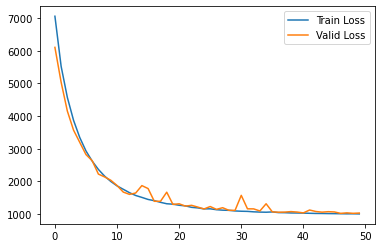

In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.show()